In [1]:
import numpy as np
import argparse
import os
import sys
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
from utils import *

from matplotlib import pyplot as plt
import random
import copy
from sklearn.model_selection import train_test_split

import skimage
from mnet import MNet
from loupe_env.loupe_wrap import *
from mask_backward_new import mask_backward, mask_eval
from sigpy.mri.app import TotalVariationRecon

sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# comparison between MNet and Loupe

In [25]:
dtyp = torch.float
testxdata  = np.load('/home/huangz78/data/testdata_x.npz')
testydata  = np.load('/home/huangz78/data/testdata_y.npz')
testxfull = torch.tensor(testxdata['xfull'],dtype=dtyp)
testyfull = torch.tensor(testydata['yfull'],dtype=torch.cfloat)

In [26]:
sparsity = .25
preselect_num = 24
unet_skip = True

In [127]:
# load mnet
mnet = MNet(beta=1,in_channels=2,out_size=320-preselect_num, imgsize=(320,320),poolk=3)
# mnetpath = '/home/huangz78/checkpoints/mnet_split_trained.pth'
mnetpath = '/home/huangz78/checkpoints/mnet.pth'
checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

unet_recon = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
unetpath = '/home/huangz78/checkpoints/unet_split_trained.pth'
checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

MNet loaded successfully from: /home/huangz78/checkpoints/mnet.pth
Unet loaded successfully from: /home/huangz78/checkpoints/unet_split_trained.pth
nn's are ready


In [28]:
def mnet_eval(mnet,unet,testdata,preselect_num,sparsity,\
             batchsize=5,mode='unet',\
             Lambda=1e-4,\
             normalize=False):
    
    # prepare test data for mnet input
    nimgs = testdata.shape[0]; heg = testdata.shape[1]; wid = testdata.shape[2]
    
    data = torch.zeros(nimgs,2,heg,wid)    
    lf_mask = mask_naiveRand(heg,fix=preselect_num,other=0,roll=False)
    data[:,0,lf_mask==1,:] = torch.real(testdata[:,lf_mask==1,:])
    data[:,1,lf_mask==1,:] = torch.imag(testdata[:,lf_mask==1,:])
    
    pred_mnet = torch.zeros((nimgs,heg))
    batchnums = int(np.ceil(nimgs/batchsize))
    batchind = 0
    while batchind < batchnums:
        batch = np.arange(batchsize*batchind, min(batchsize*(batchind+1),nimgs))
        databatch = data[batch]
        preds = mnet_wrapper(mnet,databatch,budget=int(heg*sparsity)-preselect_num,\
                             imgshape=[heg,wid],normalize=True,detach=True)
        pred_mnet[batch] = F.ifftshift(preds,dim=1)
        batchind += 1
    
    observed_kspace = torch.zeros_like(testdata)
    for ind in range(len(data)):
        observed_kspace[ind,pred_mnet[ind,:]==1,:] = testdata[ind,pred_mnet[ind,:]==1,:]
    imgs_recon = torch.zeros(testdata.shape)
    
    if mode == 'unet':
        input_unet = F.ifftn(observed_kspace,dim=(1,2),norm='ortho').abs().view(nimgs,1,heg,wid)
        batchind = 0
        while batchind < batchnums:
            batch = np.arange(batchsize*batchind, min(batchsize*(batchind+1),nimgs))
            databatch = input_unet[batch]
            if not normalize:
                imgs_recon[batch] = torch.squeeze(unet(databatch).detach())
            else:
                recon_batch = unet(databatch).detach()
                for ind in range(len(recon_batch)):
                    recon_batch[ind] = recon_batch[ind]/torch.max(torch.abs(torch.flatten(recon_batch[ind])))
                imgs_recon[batch] = torch.squeeze(recon_batch)
            batchind += 1
    elif mode == 'sigpy':
        mps = np.ones((1,heg,wid))
        for ind in range(len(observed_kspace)):
            y_tmp = observed_kspace[ind,:,:].view(-1,heg,wid).numpy()
            imgs_recon[ind,:,:] = torch.tensor(\
                       np.fft.ifftshift(np.abs(TotalVariationRecon(y_tmp, mps, Lambda,show_pbar=False).run())) )

    ssim = compute_ssim(imgs_recon,testdata)
    psnr = compute_psnr(imgs_recon,testdata)
    hfen = np.zeros((nimgs))
    for ind in range(nimgs):
        hfen[ind] = compute_hfen(imgs_recon[ind,:,:].to(torch.cfloat),testdata[ind,:,:].to(torch.cfloat))
    rmse = np.zeros((nimgs))
    for ind in range(nimgs):
        rmse[ind] = torch.norm(imgs_recon[ind,:,:] - testdata[ind,:,:],2)/torch.norm(testdata[ind,:,:],2)
    
    return ssim,psnr,hfen,rmse

In [132]:
mnet_test_mode = 'unet'
ssim_mnet,psnr_mnet,hfen_mnet,rmse_mnet = mnet_eval(mnet,unet_recon,testyfull,preselect_num=24,sparsity=.25,\
                               batchsize=5,mode=mnet_test_mode,normalize=False)

In [133]:
print('mnet test mode: ',mnet_test_mode)
print('ssim mnet: ',np.mean(ssim_mnet))
print('psnr mnet: ',np.mean(psnr_mnet))
print('hfen mnet: ',np.mean(hfen_mnet))
print('rmse mnet: ',np.mean(rmse_mnet))

mnet test mode:  unet
ssim mnet:  0.91461295
psnr mnet:  46.763016
hfen mnet:  1.0048383869717468
rmse mnet:  1.3505249071360832


In [42]:
# load unet
UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
# load loupe model
loupepath = '/home/huangz78/checkpoints/loupe_model.pt'
loupe = LOUPE(n_channels=1,unet_skip=True,shape=[320,320],slope=5,sparsity=sparsity,\
                  preselect=True,preselect_num=preselect_num,\
                  sampler=None,unet=UNET)

In [89]:
def loupe_eval(loupe,testdata,preselect_num,sparsity,\
               batchsize=5,mode='unet',\
               Lambda=1e-4):
    loupe.eval()
    if preselect_num > 0:
        assert loupe.preselect
        assert loupe.preselect_num == preselect_num
    # prepare test data for mnet input
    nimgs = testdata.shape[0]; heg = testdata.shape[1]; wid = testdata.shape[2]    
    data = torch.reshape(testdata,(nimgs,1,heg,wid))
    
    pred_loupe = torch.zeros((nimgs,heg,wid)) 
    batchnums = int(np.ceil(nimgs/batchsize))
    batchind = 0    
    if mode == 'unet':           
        while batchind < batchnums:
            batch = np.arange(batchsize*batchind, min(batchsize*(batchind+1),nimgs))
            databatch = data[batch]
            preds,_ = loupe(databatch)
            pred_loupe[batch] = torch.squeeze( preds.detach() )
            batchind += 1
    elif mode == 'sigpy':
        masks_loupe = torch.zeros((batchnums,heg))
        while batchind < batchnums:
            batch = np.arange(batchsize*batchind, min(batchsize*(batchind+1),nimgs))
            databatch = data[batch]
            _,mask = loupe.samplers[0](databatch,sparsity)

            mask = torch.squeeze(mask.detach())
            masks_loupe[batchind,:] = mask
            observed_kspace = torch.zeros_like(databatch)
            imgs_recon = torch.zeros((len(databatch),heg,wid))
            observed_kspace[:,:,mask==1,:] = databatch[:,:,mask==1,:]
            
            mps = np.ones((1,heg,wid))
            for ind in range(len(observed_kspace)):
                y_tmp = observed_kspace[ind,0,:,:].view(-1,heg,wid).numpy()
                imgs_recon[ind,:,:] = torch.tensor(\
                           np.fft.ifftshift(np.abs(TotalVariationRecon(y_tmp, mps, Lambda,show_pbar=False).run())) )
            pred_loupe[batch] = imgs_recon
            batchind += 1
        
    ssim = compute_ssim(pred_loupe,testdata)
    psnr = compute_psnr(pred_loupe,testdata)
    hfen = np.zeros((nimgs))
    for ind in range(nimgs):
        hfen[ind] = compute_hfen(pred_loupe[ind,:,:].to(torch.cfloat),testdata[ind,:,:].to(torch.cfloat))
    rmse = np.zeros((nimgs))
    for ind in range(nimgs):
        rmse[ind] = torch.norm(pred_loupe[ind,:,:] - testdata[ind,:,:],2)/torch.norm(testdata[ind,:,:],2)
    
    return ssim,psnr,hfen,rmse

In [90]:
loupe_test_mode = 'unet'
ssim_loupe,psnr_loupe,hfen_loupe,rmse_loupe = loupe_eval(loupe,testyfull,preselect_num=24,sparsity=.25,\
                               batchsize=5,mode=loupe_test_mode)

/home/huangz78/mri/utils.py:380: ComplexWarning: Casting complex values to real discards the imaginary part
  
/home/huangz78/mri/utils.py:392: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [91]:
print('mnet test mode: ',mnet_test_mode)
print('ssim loupe: ',np.mean(ssim_loupe))
print('psnr loupe: ',np.mean(psnr_loupe))
print('hfen loupe: ',np.mean(hfen_loupe))
print('rmse loupe: ',np.mean(rmse_loupe))

mnet test mode:  unet
ssim loupe:  0.872116
psnr loupe:  45.6678
hfen loupe:  1.0049172280421808
rmse loupe:  1.5112594366073608


# show masks

In [50]:
heg = 320
wid = 320
sparsity = .25
preselect_num = 24

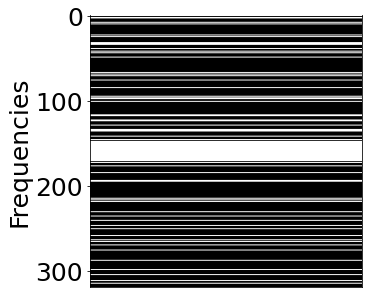

In [109]:
_,loupe_mask = loupe.samplers[0](kimg,sparsity)
loupe_mask = torch.squeeze(loupe_mask.detach())
kplot(loupe_mask,roll=True)

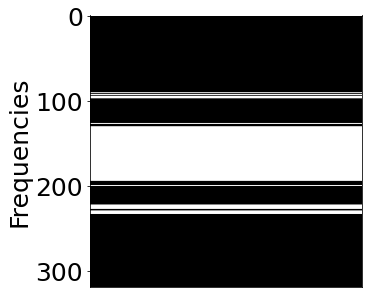

In [129]:
imgind = 126
kimg_1 = testyfull[imgind].view(1,1,heg,heg)
lfmask,_,_ = mask_naiveRand(heg,fix=preselect_num,other=0,roll=False)

kimg_lf_1 = torch.zeros(1,2,heg,wid)    
kimg_lf_1[:,0,lfmask==1,:] = torch.real(kimg_1[:,:,lfmask==1,:])
kimg_lf_1[:,1,lfmask==1,:] = torch.imag(kimg_1[:,:,lfmask==1,:])

# _,loupe_mask = loupe.samplers[0](kimg,sparsity)
# loupe_mask = torch.squeeze(loupe_mask.detach())
# kplot(loupe_mask,roll=True)

mnet_mask_1 = mnet_wrapper(mnet,kimg_lf_1,budget=int(heg*sparsity)-preselect_num,\
                             imgshape=[heg,wid],normalize=True,detach=True)
mnet_mask_1 = torch.squeeze(mnet_mask_1)
kplot(mnet_mask_1,roll=False)

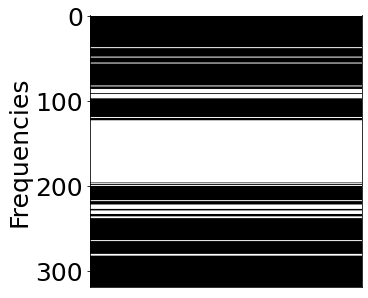

In [130]:
imgind = 36
kimg_2 = testyfull[imgind].view(1,1,heg,heg)

kimg_lf_2 = torch.zeros(1,2,heg,wid)    
kimg_lf_2[:,0,lfmask==1,:] = torch.real(kimg_2[:,:,lfmask==1,:])
kimg_lf_2[:,1,lfmask==1,:] = torch.imag(kimg_2[:,:,lfmask==1,:])

# _,loupe_mask = loupe.samplers[0](kimg,sparsity)
# loupe_mask = torch.squeeze(loupe_mask.detach())
# kplot(loupe_mask,roll=True)

mnet_mask_2 = mnet_wrapper(mnet,kimg_lf_2,budget=int(heg*sparsity)-preselect_num,\
                             imgshape=[heg,wid],normalize=False,detach=True)
mnet_mask_2 = torch.squeeze(mnet_mask_2)
kplot(mnet_mask_2,roll=False)

In [131]:
mnet_mask_1 - mnet_mask_2

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0., -1., -1., -1., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1., -1.,
        -1.,  0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [114]:
kimg_lf_1 - kimg_lf_2

tensor([[[[ 41.6377,   1.9276,  -2.7062,  ..., -13.0655,  -2.7062,   1.9276],
          [  6.6936,  -3.6715,   4.4591,  ...,  -7.6111,   1.0839,  -0.5949],
          [ -1.6467,  -1.4262,   0.8060,  ...,  -1.1578,  -0.0865,   0.6762],
          ...,
          [ -5.1692,   3.4111,   1.5353,  ...,   2.2926,   1.7272,  -1.9030],
          [ -1.6467,   0.6762,  -0.0865,  ...,   6.3253,   0.8060,  -1.4262],
          [  6.6936,  -0.5949,   1.0839,  ...,   3.7968,   4.4591,  -3.6715]],

         [[  0.0000,  -4.2498,  -5.4097,  ...,   5.0442,   5.4097,   4.2498],
          [  3.1000,   2.5610,   1.0784,  ...,  -0.0869,   1.0914,   3.5216],
          [  1.1286,   1.5147,   1.9038,  ...,   0.3866,   1.2476,   0.9357],
          ...,
          [ -4.5040,   4.2709,  -0.4760,  ...,  -3.1117,  -0.5989,   0.9476],
          [ -1.1286,  -0.9357,  -1.2476,  ...,  -1.3224,  -1.9038,  -1.5147],
          [ -3.1000,  -3.5216,  -1.0914,  ...,   1.9317,  -1.0784,  -2.5610]]]])

# mnet and loupe training error check

In [2]:
rec = np.load('/home/huangz78/checkpoints/mnet_train_history.npz')
print(rec.files)

['loss_train', 'loss', 'precision_train', 'recall_train', 'precision_test', 'recall_test']


In [ ]:
wid1 = 10
wid2 = 5
plt.figure()
plt.plot(rolling_mean(rec['precision_train'],wid1),label='precision')
plt.plot(rolling_mean(rec['recall_train'],wid1),label='recall')
plt.title('training accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('testing accuracy')
plt.plot(rolling_mean(rec['precision_test'],wid2),label='precision')
plt.plot(rolling_mean(rec['recall_test'],wid2),label='recall')
plt.legend()
plt.show()

plt.figure()
plt.title('train loss in cross entropy')
plt.plot(rolling_mean(rec['loss_train'],20),label='train')
plt.legend()
plt.show()

plt.figure()
plt.title('test loss in cross entropy')
plt.plot(rolling_mean(rec['loss'],8),color='orange',label='test')
plt.legend()
plt.show()


In [23]:
rec = np.load('/home/huangz78/checkpoints/loupe_history.npz')

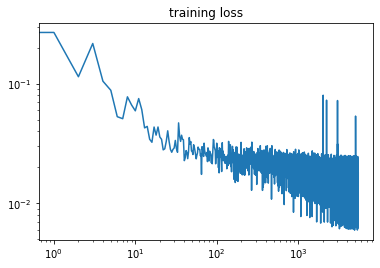

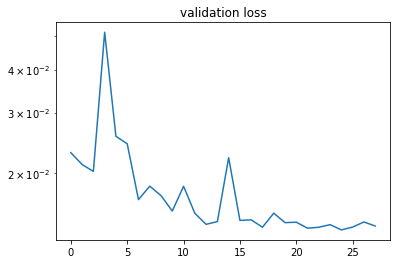

In [24]:
loss_train = rec['loss_train']
loss_val = rec['loss_val']
plt.figure()
plt.plot(loss_train)
plt.xscale('log')
plt.yscale('log')
plt.title('training loss')
plt.show()
plt.figure()
plt.plot(loss_val)
plt.yscale('log')
plt.title('validation loss')
plt.show()

In [13]:
rec = np.load('/home/huangz78/checkpoints/alternating_update_error_track.npz')
print(rec.files)

['loss_rand', 'loss_after', 'loss_before', 'freqs']


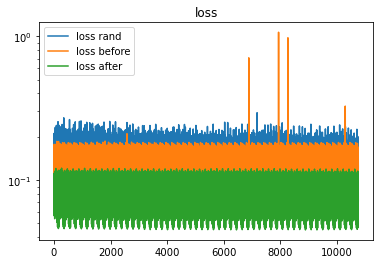

In [20]:
plt.figure()
plt.plot(rec['loss_rand']   ,label='loss rand')
plt.plot(rec['loss_before'] ,label='loss before')
plt.plot(rec['loss_after']  ,label='loss after')
plt.title('loss')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

# mnet quality check: y

In [ ]:
net = MNet(beta=1,in_channels=2,out_size=320-24,\
                   imgsize=(320,320),poolk=3)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet.pth')
net.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet.pth')
net.eval()

imgs = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
base = 24
mask_lf,_,_ = mask_naiveRand(imgs.shape[1],fix=base,other=0,roll=True)

yfulls = torch.zeros((imgs.shape[0],2,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
ys     = torch.zeros((imgs.shape[0],2,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
xs     = torch.zeros((imgs.shape[0],1,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
for ind in range(imgs.shape[0]):
    imgs[ind,:,:] = imgs[ind,:,:]/torch.max(torch.abs(imgs[ind,:,:]))
    y = torch.fft.fftshift(F.fftn(imgs[ind,:,:],dim=(0,1),norm='ortho'))
    ysub = torch.zeros(y.shape,dtype=y.dtype)
    ysub[mask_lf==1,:] = y[mask_lf==1,:]
    xs[ind,0,:,:] = torch.abs(F.ifftn(torch.fft.ifftshift(ysub),dim=(0,1),norm='ortho')) 

    yfulls[ind,0,:,:] = torch.real(y)
    yfulls[ind,1,:,:] = torch.imag(y)
    ys[ind,:,mask_lf==1,:] = yfulls[ind,:,mask_lf==1,:]

labels = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled

imgNum = imgs.shape[0]
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=round(imgNum*0.8))
test_total  = testinds.size

traindata   = ys[traininds,:,:,:]
valdata     = ys[testinds[0:test_total//2],:,:,:]

trainlabels = mask_filter(labels[traininds,:],base=base)
vallabels   = mask_filter(labels[testinds[0:test_total//2],:],base=base)

In [ ]:
imgind = 19
testimg  = valdata[imgind,:,:,:]
output_1 = net(testimg.view(-1,2,320,320))
binary_1 = sigmoid_binarize(output_1)[0,:]
greedy_1 = vallabels[imgind,:]

imgind = 13
testimg = valdata[imgind,:,:,:]
output_2 = net(testimg.view(-1,2,320,320))
binary_2 = sigmoid_binarize(output_2)[0,:]
greedy_2 = vallabels[imgind,:]

print(torch.sum(torch.abs(binary_1-binary_2)))
print(output_1 - output_2)
# sigmoid_binarize(output)[0,:]

In [ ]:
from utils import mask_complete

In [ ]:
mask_1 = mask_complete(binary_1.view(1,-1),320,rolled=True)
kplot(mask_1.view(-1))
kplot(greedy_1)

# mnet quality check: x

In [ ]:
# generate a mnet mask as an example

mnet = MNet(out_size=320-24)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet_split_trained.pth')
mnet.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet_split_trained.pth')

test_dir = '/home/huangz78/data/testdata_x.npz'
# testimg  = torch.tensor(np.load(test_dir)['x']) 
# print(testimg.shape)
# test_sub  = test_sub[0:10,:,:]
test_full = torch.tensor(np.load(test_dir)['xfull']) 
mask_greedy = np.load('/home/huangz78/data/data_gt_greedymask.npz')
mask_greedy = mask_greedy['mask'].T # this greedy mask is rolled

In [ ]:
reload(utils)
from utils import mnet_wrapper

In [ ]:
# imgind = np.random.randint(test_full.shape[0])
mnet.train()
imgind1 = np.random.randint(199)
print('current selected image is indexed: ',imgind1)
img1 = test_full[imgind1,:,:]
imgind2 = np.random.randint(199)
print('current selected image is indexed: ',imgind2)
img2 = test_full[imgind2,:,:]
# plt.imshow(img)
# plt.show()

budget = 56
lowfreqmask,_,_ = mask_naiveRand(img1.shape[0],fix=24,other=0,roll=True)
# randmask,_,_ = mask_naiveRand(img.shape[0],fix=24,other=budget,roll=True)
# kplot(randmask)

yfull1 = torch.fft.fftshift(F.fftn(img1,dim=(0,1),norm='ortho')) # y is ROLLED in this line!
yfull2 = torch.fft.fftshift(F.fftn(img2,dim=(0,1),norm='ortho')) # y is ROLLED!
yfull  = torch.stack((yfull1,yfull2),dim=0)
# x_lf_minus      = -x_lf.clone()
x_lf   = get_x_f_from_yfull(lowfreqmask,yfull,DTyp=torch.cfloat)

In [ ]:
mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) ).shape

In [ ]:
yfull1.shape

In [ ]:
mnet.eval()
mnetmask = mnet( 1e3*torch.randn(10,1,img1.shape[0],img1.shape[1]) )
# x_lf =  1e3*torch.randn(10,img1.shape[0],img1.shape[1]) 
# highmask_raw = mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) )
# mnetmask = mnet_wrapper(mnet,x_lf,budget,img1.shape)
print(mnetmask.shape)

torch.sum( torch.abs( mnetmask[0,:] - mnetmask[1,:] ) )

In [ ]:
a = torch.randn(2,2,4,5)
b = torch.randn(2,2,4,5)
c = a[:,0,:,:] + b[:,1,:,:]
print(c.shape)

In [ ]:
highmask_raw  = mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) ).view(-1)  # no sigmoid 
# highmask_raw  = mnet( 1e10*torch.randn(1,1,img.shape[0],img.shape[1]) ).view(-1)  # no sigmoid 
# print('highmask_raw = ', highmask_raw)
plt.plot(highmask_raw.detach().numpy())
plt.show()
mnetmask = mnet_wrapper(mnet,x_lf,budget,img.shape)
kplot(mnetmask)
kplot(mask_greedy[imgind,:])

In [ ]:
print(mnet.)

In [ ]:
for param in mnet.named_parameters():
      print(param)

In [ ]:
mnetmask_old = mnetmask.clone()
mnetmask - mnetmask_old

In [ ]:
randqual[1:]

In [ ]:
# show quality of mnet
filepath = '/home/huangz78/checkpoints/alternating_update_error_track.npz'
data_loss = np.load(filepath)

print(data_loss.files)

randqual   = data_loss['randqual']
mnetqual   = data_loss['mnetqual']
greedyqual = data_loss['greedyqual']
randspar   = data_loss['randspar']
mnetspar   = data_loss['mnetspar']

try:
    visualization(randqual[1:],mnetqual[1:],greedyqual=greedyqual,\
             randspar=randspar,mnetspar=mnetspar,greedyspar=greedyspar*np.ones(len(greedyqual)))
except Exception:
    visualization(randqual[1:],mnetqual[1:],randspar=randspar,mnetspar=mnetspar,log1=True)